In [1]:
from particle import Particle
from algorithms import BarnesHut
from universe import Universe
from forces import InverseSquare
import IPython.display
import numpy as np
import matplotlib.pyplot as plt

# Analysis
The most naive way to calculate the forces in a system of particles is called the pair-wise (PW) algorithm. The interactions between each particle pair are calculated directly, the are $\frac{N(N+1)}{2}$ pairs of particles for an N-particle system. The PW algorithm therefore has $O(N^2)$ time complexity, this is not scalable for large numbers of particles, so I seek to investigate different algorithms and how their respective performance and accuracy compare.

## Barnes-Hut Algorithm
The Barnes-Hut (BH) Algorithm divides space into quadrants, to form a quadtree of particles. For the PW algorithm, the interaction list length for each particle is $O(N)$, updating every particle is therefore $O(N^2)$ complexity. Using the quadtree structure, the tree can be iterated through recursively, making approximations at each level. The approximation reduces the interaction list length to $O(\log{N})$ resulting in overall $O(N \log{N})$ complexity.

The reduction in computation time comes at the cost of accuracy, controlled by a parameter $\theta$. For a quadrant with width $d$, that is a distance $r$ away from a point, the ratio $\frac{d}{r}$ is considered. If $\frac{d}{r} \lt \theta$ the quadrant is sufficiently far away and we can approximate the interaction with the centre of charge, rather than each individual particle. If $\frac{d}{r} \ge \theta$, the algorithm is repeated recursively for each sub-quadrant.

The actual time complexity depends on the value of $\theta$, for example when $\theta=0$ the approximation is never made and interaction list contains all the particles. This is simply just the PW algorithm with $O(N^2)$ complexity. However, as $\theta \to \infty$, the approximation is always taken at the root of the tree meaning the interaction list always contains only one item, the performance in this case would be $O(N)$

### Filling the Quadtree

The Quadtree class has two states, whether it has been *divided* or not. A divided quadtree contains 4 children quadtrees and no particles, an undivided quadtree contains no children and a list of particles. The first particle is added to the quadtree particle list, when the second particle is added, the quadtree must divide and the particles are added to the children quadtrees. This process of either appending the particle to the list, or dividing and passing the particle to th children is continued until there are no more particles to add or the maximum depth is reached.

<img src="diagrams/tree_fill.jpeg" width=800px>

### Finding the Interaction List

The interaction list is the list of charges that a particle must interact with. To find the interaction list for a particle, the ratio $\frac{r}{d}$ is calcualted for the root quadtree, if this ratio is $\lt\theta$, the quadrant is far enough away from the particle that we can approximate and only append the quadrant's centre of charge, instead of every particle that the quadrant contains. However, if the ratio $\frac{r}{d} \ge \theta$, the particle is too close to the quadrant to make this approximation and the interaction list is the union of the interaction lists of the sub-quadrants.

Once the tree has been traversed, the interaction list contains particles and centres of charges for which the interaction is calculated directly. The diagram below shows how the interaction list for the point in black is found, with the final interaction list at the end.

<img src="./diagrams/algorithm.jpeg" width="800px">

The adaptive quadtree structure, and interaction list for a point at the centre are displayed below

<img id="BH_squares" src="animations/BH.gif" width="600px">
<img src="animations/BH_clusters.gif" width="600px">


## Fast Multipole Method (FMM)

The fast multipole method is another algorithm to calculate interactions between particles with complexity $O(N)$. FMM has some similarities to BH in the grid structure, however instead of calculating centres of charges, multipole expansions are calculated with the number of terms defining the accuracy of the algorithm.

### Calculating Multipoles

For a 2D simulation, the system can be viewed as particles lying in a plane in 3D, or a universe that is only 2D. The interactions between particles will depend on whichever viewpoint is taken. For FMM, I will consider a 2D universe with force $F(r) \propto \frac{1}{r}$ and potential $\Phi(r) \propto \ln(r)$. To make the mathematics easier, complex numbers are used as position coordinates, with their real/imaginary components corresponding to the $x/y$ coordinates. Expressing a complex number in exponential form makes the potential calculation simple. 
$$z = r e^{i\theta}$$
$$\ln(z) = \ln(r) + i\theta$$
The potential is then simply just the real part of $\ln(r)$ where r is the difference between the locations of two particles.

For a cluster of charges located at the points $\{z_i, i=0, 1, 2, ...\}$, the potential induced by the charges at a location $z$ is given by the multipole expansion: $$\phi(z) = Q \ln(z) + \sum_{k=1}^\infty \frac{a_k}{z^k}$$
with total charge $Q$ and expansion coefficients $a_k$

$$
Q = \sum_{i=1}^m q_i, \hspace{0.5cm} a_k = \sum_{i=1}^m \frac{-q_i z_i^k}{k}
$$

### Multipole Errors

The error in the multipole expansion depends on the number of terms $p$. If the cluster of particles has *radius* $r$ the absolute error in the potential for any $p \ge 1$ is constrained by:
$$\begin{align*}
\bigg|\phi(z) - Q \ln(z) - \sum_{i=1}^p \frac{a_k}{z^k}\bigg| &\le \frac{1}{p+1} \alpha \bigg| \frac{r}{z} \bigg|^{p+1}\\
&\le \frac{A}{p-1} \frac{1}{c-1} \left(\frac{1}{c}\right)^p
\end{align*}
$$

$$c = \bigg| \frac{z}{r} \bigg|, \hspace{.5cm}
A = \sum_{i=1}^m |q_i|, \hspace{.5cm}
\alpha = \frac{Ac}{c-1}$$

Therefore, because of the $\left(\frac{1}{c}\right)^p$ factor in the error, for a given tolerence $\epsilon$ in the potential, use $p = -\log_c{\epsilon}$ terms in the multipole expansion

### Partitioning Space

Considering the case of uniform particle distribution, the space can be split into grids of different layers, each layer containing cells with half the size of the layer above. More sophisticated methods can be used, for example an adaptive tree structure would be better suited for non-uniform particle distributions. For the simpler case, the data structure consists of a list of $2^l \times 2^l \times p$ arrays where $l$ is the depth of the layer, and $p$ is the number of terms in the expansion to store.

The terminology I will frequently use:

**Neighbour** : cell-1 is a neighbour of a cell-2 if there are no cells inbetween cell-1 and cell-2, and the cells are on the same layer. This includes diagonals

**Well-Seperated** : The well-seperated cells of cell-1 are the children of the cells that are siblings of the parent of cell-1, and that are also not neighbours of cell-1. A close analogy for this is the *cousins* of cell-1

<img src="diagrams/structure.jpeg" width=800>

### Upward Pass

The first step of the algorithm is the upward pass. Starting at the leaf layer, each multipole expansion is converted into another multipole expansion located at the centre of the parent cell. This is repeated for every cell in every layer, moving upwards. The Multipole-Multipole conversion will be called M2M

The conversion of the expansion coefficients going from $z_C$ to $z_M$ is given by the following transformation:
$$\phi(z) = b_0 \ln(z-z_M) + \sum_{l=1}^p \frac{b_l}{(z-z_M)^l} + O(\epsilon)\\
b_0 = a_0, \hspace{0.5cm} b_l = -\frac{a_0(z_C-z_M)^l}{l} + \sum_{k=1}^l a_k(z_C - z_M)^{l-k} {l-1 \choose k-1}$$

<img src="diagrams/upward.jpeg" width=800>

The diagram above demonstrates how the M2M algorithm works for each layer. The red points representing the multipole expansions at the finest level, are combined to form a new multipole expansion for the partent cell, and so on.

### Downward Pass

The downward pass does two things at each layer, a multipole-to-local expansion conversion (M2L) and local-to-local expansion conversion (L2L).

M2L considers all the well-seperated cells of a cell and converts their multipole expansions into local expansions located at the centre of the cell. This is done for every cell in the layer. The local expansion coefficients going from $z_M$ to $z_L$ are:
$$\phi(z) = \sum_{l=0}^p c_l(z-z_L)^l + O(\epsilon)$$
$$c_0 = b_0 \ln(z_L - z_M) + \sum_{k=1}^p \frac{(-1)^k b_k}{(z_M-z_L)^k}, \\
c_l = -\frac{b_0}{l(z_M - z_L)^l} + \frac{1}{(z_M - z_L)^l} \sum_{k=1}^p \frac{(-1)^k b_k}{(z_M-z_L)^k} {l+k-1 \choose k-1}$$
L2L then converts the local expansion of a cell into more local expansions located at the centres of the the cell's children. The new expansion coefficients going from $z_L$ to $z_T$ are:
$$\phi(z) = \sum_{l=0}^p d_l (z-z_T)^l\\
d_l = \sum_{k=1}^p c_k {k \choose l} (z_T - z_L)^{k-l}$$


<img src="diagrams/downward.jpeg" width=800>

The first image demonstrates the first M2L conversion with blue arrows, and then the first L2L conversion with red arrows<br>
The second image demonstrates the second (and final) M2L conversion<br>
The final image shows the cells for which the interactions must be calculated directly in green

As shown in the diagram above, performing M2L at each layer means that the multipole expansions of every particle in the grid are taken into consideration (except nearest neighbours). After the downward pass, the algorithm is finished and the potentials or forces can be calculated. As well as the multipole expansion, the interactions between particles in neighbouring cells needs to be computed directly.

### Forces and Potentials

The potential is given by the expansion $\phi(z) = \sum_{l=0}^p d_l(z-z_T)^l$ where $d_l$ are the local expansion coefficients
To get the force, the gradient of the expansion is taken, using the Cauchy-Riemann equations. For the potential $\phi(z) = \Re(w(z))$, the gradient is 
$$\nabla \phi = (f_x, f_y) = \left(\Re(\frac{\partial w}{\partial z}), -\Im(\frac{\partial w}{\partial z})\right)$$

$$
\begin{align*}
F &= -\nabla \phi(z) \\
&= \sum_{l=1}^p l d_l(z-z_T)^{l-1}\\
\end{align*}
$$

Finally our force components are 
$$F_x = \Re(F) \hspace{0.5cm} F_y = -\Im(F)$$

### FMM Complexity

1. Multipole Expansions for each particle - $O(Np)$
    - $N$ particles, each with $p$ terms
2. M2M - $O(Np^2)$
    - Each expansion term for the parent cell depends on every term of the child cell, resulting in quadratic dependence on p
3. M2L - $\le O(27Np^2)$
    - There are at most $27$ well-seperated cells
    - It is quadratic in $p$ for the same reason as M2M
4. L2L - $O(Np^2)$
    - L2L is similar to M2M, but in reverse
5. Evaluate local expansions for each particle - $O(Np)$
    - $N$ particles, each with $p$ terms to compute
6. Direct neighbour interactions - $O(\frac{9}{2}Nk_n)$
    - There are at most $9$ nearest neighbour cells to interact with, each containg $k_n$ particles
    - The potentials between pairs of particles are symmetrical, so need only be calculated once, introducing the factor of $\frac{1}{2}$
7. Combining far-field expansions and direct interactions - $O(N)$
    - Addition of two complex numbers for each of the $N$ particles

Each step in the algorithm has complexity that is linear in $N$, therefore the overall time complexity of FMM is $O(N)$

# Implementation

My aim was to write code that made switching between algorithms as easy as possible, I created an **Algorithm** abstract class that each algorithm could inherit from. Combined with a universe class and a particle class, the system can simulate and animate the interactions for any algorithm. The following code has been simplified to show only the essential functionality of each class.

### Particle Class

The **Particle** class contains the necessary properties for an interacting particle - mass, charge, position, velocity and potential. There is also the **index** method, this returns the index of the cell that the particle would lie in if it were in a quadtree like structure. The particle position and velocity are stored as complex numbers with the real/imaginary components corresponding to the x/y coordinates. If the interaction is gravitational, the charge is equal to the mass.
```python
class Particle:
    def __init__(self, charge: float, mass: float, 
                 centre: complex, velocity: complex) -> None:
    self.charge = charge
    self.mass = mass
    self.centre = centre
    self.velocity = velocity
    self.potential = 0

    def index(self, level: int) -> Index:
        i = int(self.centre.imag * 2 ** level)
        j = int(self.centre.real * 2 ** level)

        return Index(i, j, level)
```

### Algorithm Class

The **Algorithm** abstract class contains the necessary functions for an interaction algorithm, e.g. PW, BH, FMM...

The method **calculate_accelerations()** takes a list of **Particle** objects and returns a list of complex numbers, representing the accelerations of each particle. This method is an **abstractmethod** since the **Universe** class calls this method regardless of which algorithm is being used.

```py
 class Algorithm(ABC):
    def __init__(self):
        self.calculate_potential = None

    @abstractmethod
    def calculate_accelerations(self, particles: list[Particle]) -> \
            NDArray[complex]:

        return NDArray[complex]

    @abstractmethod
    def animate(self, fig: plt.Figure, ax: plt.Axes, scatter: 
                plt.Subplot, **kwargs) -> None:
        return
```

### Force Class

To be able to interchange force types easily, I created the **Force** class. The class contains two functions **calculate_force()** and **calculate_potential()**, to calculate the forces and potentials for particles within the force field. For example the **InverseSquare** force class, the force depends on the inverse square of the distance between the particles, however we introduce the **softening** parameter $s$ that reduces divergent forces for small distances, this affects the potential between the particles as well.

$$
\vec{F} = -\nabla \phi = \frac{q_1 q_2}{4 \pi (r^2 + s^2)}
$$
$$
\begin{align*}
\phi &= - \frac{q_1 q_2}{4 \pi}\int_R^\infty \frac{1}{r^2+s^2}\\
&= - \frac{q_1 q_2}{4 \pi}\left[\frac{\pi}{2s} - \frac{1}{s} \arctan{\frac{r}{s}}\right]\\
&= \frac{q_1 q_2}{8 \pi}\left[\frac{2}{\pi} \arctan{\frac{r}{s}} - 1\right]

\end{align*}
$$
<div style="justify-content:center; display:flex; gap:50px">
    <span style="text-align:center">
        <div>Softened (black) vs Un-softened (purple) force</div>
        <img src="diagrams/softened_force.png" height=300>
    </span>
    <span style="text-align:center">
        <div>Softened (blue) vs Un-softened (red) potetntial</div>
        <img src="diagrams/softened_potential.png" height=300>
    </span>
</div>



```py
class InverseSquare(Force):
    def __init__(self, K: float, softening: float) -> None:
        self.K = K
        self.SOFTENING = softening

    def calculate_force(self, particle1: Particle, particle2: Particle) -> \
            complex:
        r = particle2.centre - particle1.centre
        d = abs(r)
        force = -self.K * particle1.charge * particle2.charge * r / (
                    d * (d ** 2 + self.SOFTENING ** 2))
        return force

    def calculate_potential(self, particle1: Particle, particle2: Particle) ->\
            float:
        potential = 0
        z = particle1.centre - particle2.centre
        q1 = particle1.charge
        q2 = particle2.charge
        s = self.SOFTENING
        if s == 0:
            potential = -q1*q2 / (4*np.pi*abs(z))
        else:
            potential = q1*q1 / (8*s) * (
                2/np.pi * np.arctan(abs(z)/s) - 1
            )
        return potential
```

### Integration Schemes

The final object needed to run the simulation is the numerical integration scheme. Integration schemes are functions within the integration.py file. Each function updates the position and velocity of the particles, the Euler integration scheme is given below.

```py
def euler(particles: list[Particle], algorithm: Algorithm, 
          dt: float) -> None:
    s = np.array([p.centre for p in particles])
    v = np.array([p.velocity for p in particles])

    a = algorithm.calculate_accelerations(particles)
    v += a * dt
    s += v * dt

    for particle, pos, vel in zip(particles, s, v):
        particle.centre = pos
        particle.velocity = vel
    return
```

### Index Class

The **Index** class is only used in the FMM algorithm, since the partitioning of space is uniform, we don't need to store an adaptive quadtree like for the BH algorithm. We can simply assign an index to each particle for which cell they would lie in. The essential methods are shown below, allowing the children, parents, well-seperated cells and neighbours to be found for a particular index. The level of the index determines which layer of the quadtree it lies in, layer $l$ is a $2^l \times 2^l$ grid of cells.

```py
class Index:
    def __init__(self, i: int, j: int, level: int) -> None:
        self.index = (i, j)
        self.level = level

    def children(self) -> list[Index]:

    def parent(self) -> Index:

    def neighbours(self) -> set[Index]:

    def well_seperated(self) -> set[Index]:
```


### Universe Class

The final class needed is the **Universe** class, it consists of a list of **Particles**, an **Algorithm**, an **Integration** scheme and a **Force** type. The universe combines all the functionality of each object and adds extra functionality, like the ability to create animations of the particles. Some example code for the implementation is shown below.

In [2]:
%matplotlib notebook

N = 100
THETA = 0.5
G = -0.1
SOFTENING = 0.01
DT = 0.01

particles = [Particle(charge=0.1) for _ in range(N)]
force = InverseSquare(G, SOFTENING)
algorithm = BarnesHut(force, THETA)
universe = Universe(particles, algorithm, DT, periodic_boundary=True)

IPython.display.HTML(universe.animation(notebook=True).to_jshtml())

<IPython.core.display.Javascript object>

# Results
## Computation Time Analysis

Now that different algorithms can be implemented by changing one line of code, the time complexity of the different algorithms can be compared with ease. The time taken to calculate the accelerations for a certain configuration of particles was timed and averaged in **timings.ipynb**, the results were saved to **data/timings.npz** and the analysis of the timings will be conducted below.

To get an accurate estimate for the variance in the gradient of our regression, the **polyfit** function has a **weight** parameter. The weights are chosen so that values with higher variances have less effect, this is done with an inverse standard-deviation weighting $w=\frac{1}{\sigma}$. The power law relationship is found by taken $\ln$ of the computation times, therefore we need to find the variance of $\ln(t)$. This can be estimated using the delta method, by expanding $\ln(t)$ about the mean value $\bar{t}$

$$
\begin{align*}
\ln(t) &\approx \ln(\bar{t}) + \frac{\partial}{\partial t} \ln(t)\bigg|_{t=\bar{t}} \left(t - \bar{t}\right)\\
&\approx \ln(\bar{t}) + \frac{1}{\bar{t}} \left(t - \bar{t}\right)
\end{align*}
$$

Taking the variance of both sides

$$
Var[\ln(t)] \approx \frac{1}{(\bar{t})^2} Var[t]
$$

The weights to use are therefore 
$$w = \frac{1}{\sqrt{Var[\ln(t)]}} = \frac{\bar{t}}{\sigma_t}$$

### Algorithm Comparison

The monte-carlo method was used to measure the time taken for each algorithm to calculate the accelerations for a random selection of particle positions. The average time and variance were found and used to estimate the order of the time complexity of the algorithm, by regressing $\ln(t)$ against $\ln(N)$.

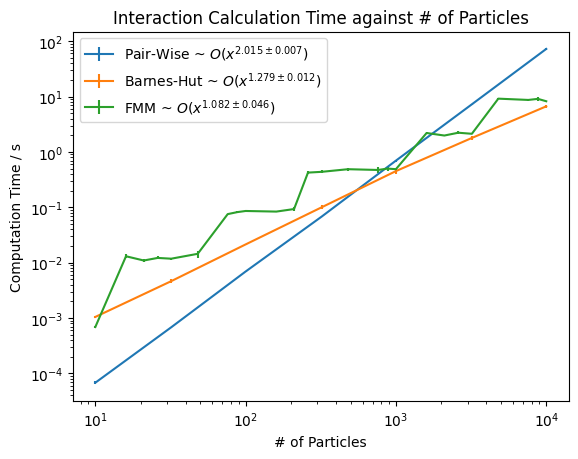

In [3]:
%matplotlib inline

# Load computation time data for each algorithm
PW_TIME = np.load("data/PW_TIME.npz")
PW_AVG = PW_TIME["avg"]
PW_STD = PW_TIME["std"]
PW_Ns = PW_TIME["Ns"]

BH_TIME = np.load("data/BH_TIME.npz")
BH_AVG = BH_TIME["avg"]
BH_STD = BH_TIME["std"]
BH_Ns = BH_TIME["Ns"]

FMM_TIME = np.load("data/FMM_TIME.npz")
FMM_AVG = FMM_TIME["avg"]
FMM_STD = FMM_TIME["std"]
FMM_Ns = FMM_TIME["Ns"]

# Fit regression lines to data
PW_REGRESSION = np.polyfit(np.log(PW_Ns), np.log(PW_AVG), 1, cov=True, w=PW_AVG/PW_STD)
BH_REGRESSION = np.polyfit(np.log(BH_Ns), np.log(BH_AVG), 1, cov=True, w=BH_AVG/BH_STD)
FMM_REGRESSION = np.polyfit(np.log(FMM_Ns), np.log(FMM_AVG), 1, cov=True, w=FMM_AVG/FMM_STD)

PW_POWER, PW_POWER_ERR = PW_REGRESSION[0][0], np.sqrt(PW_REGRESSION[1][0, 0])
BH_POWER, BH_POWER_ERR = BH_REGRESSION[0][0], np.sqrt(BH_REGRESSION[1][0, 0])
FMM_POWER, FMM_POWER_ERR = FMM_REGRESSION[0][0], np.sqrt(FMM_REGRESSION[1][0, 0])

# Generate LaTeX labels
PW_LABEL = r"Pair-Wise ~ $O(x^{"+ f"{PW_POWER:.3f} \pm {PW_POWER_ERR:.3f}" +"})$"
BH_LABEL = r"Barnes-Hut ~ $O(x^{"+ f"{BH_POWER:.3f} \pm {BH_POWER_ERR:.3f}" +"})$"
FMM_LABEL = r"FMM ~ $O(x^{"+ f"{FMM_POWER:.3f} \pm {FMM_POWER_ERR:.3f}" +"})$"
plt.errorbar(PW_Ns, PW_AVG, PW_STD, label=PW_LABEL)
plt.errorbar(BH_Ns, BH_AVG, BH_STD, label=BH_LABEL)
plt.errorbar(FMM_Ns, FMM_AVG, FMM_STD, label=FMM_LABEL)

plt.legend()

plt.title("Interaction Calculation Time against # of Particles")
plt.xlabel("# of Particles")
plt.ylabel("Computation Time / s")

plt.xscale("log")
plt.yscale("log")
# plt.savefig("figures/TIME.png", dpi=300)



As expected the naive PW algorithm scales quadratically with the particle number, and the FMM algorithm is $O(N)$. The BH algorithm is $O(N\log(N))$ so does not have a simple power law relationship, but it is seen that it's curve lies between the PW and FMM algorithms, which is to be expected for $O(N\log(N))$. Another observation is that both PW and BH algorithms have very straight lines and low variances in their gradients, however the FMM plot is not as simple. Because the FMM tree structure has a fixed depth that depends on the particle number. There are discrete jumps in the depth every time the particle number increases above a power of 4, this sudden increase in complexity of the tree structure increases the computation time for algorithm, resulting in the staircase like plot above.

### Theta Dependence

There is no clear theory for the exact dependence that computation time has on the parameter $\theta$, however in order to find a balance between accuracy and efficiency, this relationship must be investigated.

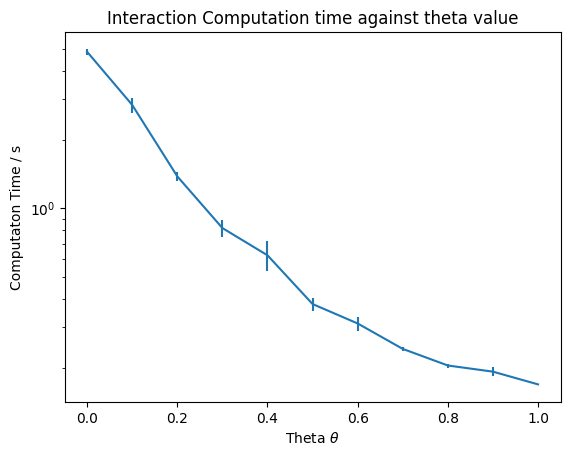

In [7]:
# Load computation time data
BH_THETA_TIME = np.load("data/BH_THETA_TIME.npz")
BH_THETA_TIME_AVG = BH_THETA_TIME["avg"]
BH_THETA_TIME_STD = BH_THETA_TIME["std"]
BH_THETA_TIME_THETAS = BH_THETA_TIME["thetas"]

plt.errorbar(BH_THETA_TIME_THETAS, BH_THETA_TIME_AVG, BH_THETA_TIME_STD)
plt.title("Interaction Computation time against theta value")
plt.xlabel(r"Theta $\theta$")
plt.ylabel("Computaton Time / s")
plt.yscale("log")
# plt.savefig("figures/BH_THETA_TIME", dpi=300)


Plotting the log of computation time against theta, the relationship is near linear. The computation time decreases approximately exponentially with $\theta$, at least within the region 0 - 1

### Precision Dependence

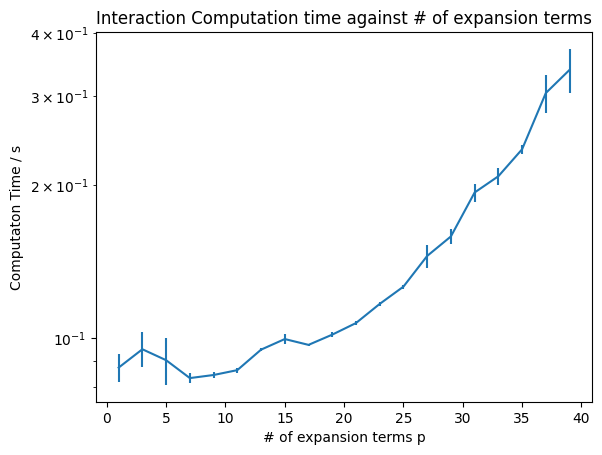

In [5]:
FMM_P_TIME = np.load("data/FMM_P_TIME.npz")
FMM_P_TIME_AVG = FMM_P_TIME["avg"]
FMM_P_TIME_STD = FMM_P_TIME["std"]
FMM_P_TIME_PS = FMM_P_TIME["Ps"]

plt.errorbar(FMM_P_TIME_PS, FMM_P_TIME_AVG, FMM_P_TIME_STD)
plt.title("Interaction Computation time against # of expansion terms")
plt.xlabel("# of expansion terms p")
plt.ylabel("Computaton Time / s")
plt.yscale("log")
# plt.savefig("figures/FMM_P_TIME", dpi=300)

## Accuracy Analysis

The PW algorithm is by far the slowest algorithm out of the three, however, becuase of its brute force nature it is the most accurate. Every interaction between every pair of particles is considered, so the accuracy is limited by the accuracy of the floating point numbers used in the calcualtions. The other two algorithms make approximations so we expect them to have much larger errors.

## Acceleration Error

### Barnes-Hut Acceleration Error

In [6]:
data = np.load("data/BH_ERR.npz", allow_pickle=True)
ERRORS = data["errors"].item()
ERRORS_STD = data["errors_std"].item()
THETAS = data["THETAS"]

for N in ERRORS:
    plt.errorbar(THETAS, ERRORS[N], ERRORS_STD[N], label=f"{N=}")

plt.xlabel(r"Theta $\theta$")
plt.ylabel("Mean Error per Particle")

plt.title(r"Error in acceleration against $\theta$")
plt.legend(loc="upper left")

# plt.yscale("log")
# plt.xscale("log")
# plt.savefig("figures/BH_ERR.png", dpi=300)

FileNotFoundError: [Errno 2] No such file or directory: 'data/BH_ERR.npz'

### FMM Acceleration Error

In [ ]:
data = np.load("data/FMM_ERR.npz")
ERRORS = data["errors"]
ERRORS_STD = data["errors_std"]
PRECISIONS = data["PRECISIONS"]
G = data["G"].item()
N = data["N"].item()
MAX_DEPTH = data["MAX_DEPTH"].item()

plt.errorbar(PRECISIONS, ERRORS, ERRORS_STD)

plt.xlabel("# Expansion Terms")
plt.ylabel("Mean Error Per Particle")

plt.title("Error in acceleration against multipole expansion terms")
plt.text(0, 8, f"{N=}, {G=}, {MAX_DEPTH=}")

plt.yscale("log")
# plt.xscale("log")
# plt.savefig("figures/FMM_ERR.png", dpi=300)

## Momentum Error

In [ ]:
data = np.load("data/MOMENTUM_ERR.npz")
TIMES = data["times"]
PW_MOMS = data["PW"]
BH_MOMS = data["BH"]
FMM_MOMS = data["FMM"]
PRECISION = data["P"]
THETA = data["theta"]

plt.plot(TIMES, PW_MOMS, label="Pair-wise")
plt.plot(TIMES, FMM_MOMS, label=f"FMM p={PRECISION}")
plt.plot(TIMES, BH_MOMS, label=rf"Barnes-Hut $\theta={THETA}$")
plt.xlabel("Time")
plt.ylabel("Total Momentum")
plt.title("Fluctation of Momentum Over Time")
plt.legend()

## Energy Error

In [ ]:
PW_data = np.load("data/PW_ENERGY.npz")
PW_TIMES = PW_data["times"]
PW_KIN = PW_data["kin"]
PW_POT = PW_data["pot"]

BH_data = np.load("data/BH_ENERGY.npz")
BH_TIMES = BH_data["times"]
BH_KIN = BH_data["kin"]
BH_POT = BH_data["pot"]
THETA = BH_data["THETA"]

FMM_data = np.load("data/FMM_ENERGY.npz")
FMM_TIMES = FMM_data["times"]
FMM_KIN = FMM_data["kin"]
FMM_POT = FMM_data["pot"]
PRECISION = FMM_data["P"]

fig, axs = plt.subplots(1, 3, figsize=(12,4), sharey=True)

PW_KIN = np.subtract(PW_KIN, PW_KIN[0])
PW_POT = np.subtract(PW_POT, PW_POT[0])
BH_KIN = np.subtract(BH_KIN, BH_KIN[0])
BH_POT = np.subtract(BH_POT, BH_POT[0])
FMM_KIN = np.subtract(FMM_KIN, FMM_KIN[0])
FMM_POT = np.subtract(FMM_POT, FMM_POT[0])

axs[0].plot(PW_TIMES, PW_KIN )
axs[0].plot(PW_TIMES, PW_POT)
axs[0].plot(PW_TIMES, np.add(PW_KIN, PW_POT))

axs[1].plot(BH_TIMES, BH_KIN )
axs[1].plot(BH_TIMES, BH_POT)
axs[1].plot(BH_TIMES, np.add(BH_KIN, BH_POT))

axs[2].plot(FMM_TIMES, FMM_KIN )
axs[2].plot(FMM_TIMES, FMM_POT)
axs[2].plot(FMM_TIMES, np.add(FMM_KIN, FMM_POT))

max_energy = np.max((np.max(abs(PW_KIN)), np.max(abs(PW_POT)),
                     np.max(abs(BH_KIN)), np.max(abs(BH_POT)),
                     np.max(abs(FMM_KIN)), np.max(abs(FMM_POT)),))

for ax in axs:
    ax.set_ylim(-1.1 * max_energy, 1.1 * max_energy)